# Chapter 7 Ensemble Learning and Random Forests

In this notebook we will go through ensemble learning methods. An *ensemble* is a group of predictors (classifiers or regressors) whose aggregated prediction is better than the prediction of each individual predictor. This is known as the *wisdom of the crowd*.

At the end of a project you will often create an ensemble from all the different well-performing models you built and tested along the way. This is a way of making your final model as good as possible. Instead of relying on one good model, use the aggregated prediction from a few good mdels that differ in their methods and such.

## Voting classifiers

If you have built a few different classifier models (logistic regression clf, decision tree clf, svm clf etc) on a particular dataset that all perform reasonably well (around 80%), a simple way to get an even better classifier is to aggregate the predictions of each classifier and predict the class with the most votes. This majority-vote classifier is a *hard-voting* classifier.

Even if the models are *weak learners* (predicting slightly better than just guessing), the ensemble can be a *strong learner* (high accuracy) due to the *law of large numbers*. Provided there are enough contributing models.

The key thing to consider is that the models should be as independent from each other as possible (eg different training algorithms or different models all together) so that the models don't all make the same types of errors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_clf = LogisticRegression()
forest_clf = RandomForestClassifier(n_estimators=10, random_state=10)
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', forest_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [2]:
from sklearn.metrics import accuracy_score
for clf in(log_clf, forest_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.87
SVC 0.87
VotingClassifier 0.88


C:\Users\21493806\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


So the classifier which takes the vote between all three classifiers performs better than each individual classifier. (This is actually not the case all the time for this dataset. Depending on the random_state hyperparameter, sometimes the random forest actually is the best. This is certainly not the general case for an arbitraty dataset)

*Soft voting* is when the ensemble model predicts the class which has the highest probability averaged over all the individual models. In this case, the models need to have a predict_proba() method. This type of voting gives higher weight to more confident models and so often gives better accuracy than hard voting. Lets do this:

In [3]:
log_clf = LogisticRegression()
forest_clf = RandomForestClassifier(n_estimators=10, random_state=10)
# by default the SVC class does not make predictions based on probabilities. Setting the probability
# hyperparameter to True makes the class use cross validation to calculate probailities for classes.
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', forest_clf), ('svc', svm_clf)],
    # Simply change the voting hyperparameter to 'soft'
    voting='soft'
)

for clf in(log_clf, forest_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.87
SVC 0.87
VotingClassifier 0.91


C:\Users\21493806\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


For this dataset, all the models are performing well, so it is hard to see the benefit of the voting classifier, but it is improved slightly with the soft voting (again, it depends on the random_state hyperparameter to determine how the accuracy changes).

## Bagging and Pasting

In order to get a diverse ensemble, you can either train the models using very different algorithms, or to use the same algorithms but train them on different random subsets of the training set.

In *bagging* (short for *bootstrap aggregating*), the sampling is performed *with* replacement (called 'bootstrapping' in statistics). This means that an training instance can be sampled again for the same predictor.

In *pasting*, the sampling is performed *without* replacement. So a predictor can only be trained by a particular instance once.

The reason one would choose bagging is that the sampled instances are independant: the probability of sampling one instance is not affected by the sampling of the other. Sampling without replacement changes the dataset size and thus the probability of sampling a particular instance. This means there is a non-zero covariance between two samples which can complicate things.

The final prediction is typically the *statistical mode* (hard voting) for classifiers or the average for regression. Aggregation reduces both bias and variance.

Bagging and pasting scale well with the size of the problem since the individual models can be trained and evaluated in parallel (multiple cores or servers).

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    # if the base classifier has a predict_probas method, then BaggingClassifier will use soft voting
    # DecisionTreeClassifier has a predict_probas method
    DecisionTreeClassifier(), 
    # n_estimators is the number of models to train
    n_estimators=500, 
    # max_samples is the number of instances to sample from the training set
    max_samples=100,
    # bootstrap=True is for bagging while bootstrap=False is for pasting
    bootstrap=True,
    # n_jobs=-1 distributes the computation over multiple cores
    n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print("Bagging classifier", accuracy_score(y_pred, y_test))

Bagging classifier 0.91


In [5]:
# create a mesh to cover the data space
mesh_x1, mesh_x2 = np.meshgrid(np.arange(X[:, 0].min() - 0.2, X[:, 0].max() + 0.2, 0.01),
                              np.arange(X[:, 1].min() - 0.2, X[:, 1].max() + 0.2, 0.01))

titles = (
    "Single Decision Tree",
    "Bagging ensemble of 500 trees"
)
tree_clf = DecisionTreeClassifier()
models = (clf.fit(X_train, y_train) for clf in (tree_clf, bag_clf))

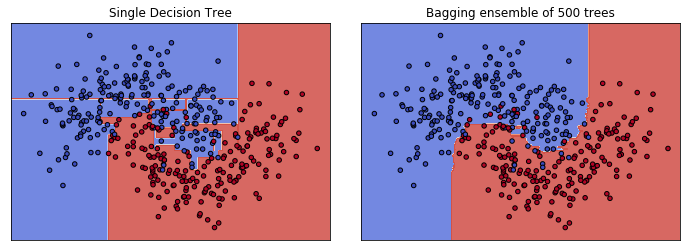

In [6]:
fig, sub = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    mesh_predict = clf.predict(np.c_[mesh_x1.ravel(), mesh_x2.ravel()]).reshape(mesh_x1.shape)
    ax.contourf(mesh_x1, mesh_x2, mesh_predict, cmap=plt.cm.coolwarm, alpha=0.8)
    
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(mesh_x1.min(), mesh_x1.max())
    ax.set_ylim(mesh_x2.min(), mesh_x2.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

THe bias in each case is roughly the same as each model still makes the same number of mistakes on the training set. However, since the decision boundary is much more smooth in the bagging ensemble, the variance is lower and will generalise better.

This is generally the case with ensemble models, the bias is similar but the variance is lower than for a sinle predictor.

Since bootstrapping introduces a but more diversity in the subsets (due to duplicated instances, each subset will have less information about the 'shape' of the dataset, so each subset will come with different assumptions about the dataset), bagging ends up with slightly higher bias than pasting.

## Out-of-bag evaluation

For a training set of m instances, the default BaggingClassifier will sample m instances with replacement. For pasting, the subset would be the same as the training set, but since bagging samples with replacement, only about 63% of the instances end up in the sampled set. The remaining 37% will be unseen by the predictor during training and can be used for evaluation (similar to cross-validation). These instances are called *out-of-bag* (oob) instances. 

Setting oob_score=True makes the BaggingClassifier calculate the evaluation score for us:

In [7]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),  n_estimators=500, max_samples=100,bootstrap=True, n_jobs=-1, 
    oob_score=True)

bag_clf.fit(X_train, y_train)
print(bag_clf.oob_score_)

0.9275


According to the oob score, the bagging classifier should score about 92% on the test set.

We can also sample from the features using the hyperparameters max_features (randomly choose a subset of the features to work with) and bootstrap_features (choosing wether to sample the features with or without replacement). 

Sampling the features but not the instances is called a **Random Subspaces** method. Sampling both instances and features is called a **Random Patches** method.

Sampling features will result in an even higher bias than sampling instances, but will lower variance more.

## Random Forests

Random forests are ensembles of decision trees, trained using either bagging or pasting. while you can use BaggingClassifier bag any type of model, it is more optimised to use the RandomForestClassifier  class (or RandomForestRegressor for regression tasks) for bagging decision trees.

In [8]:
from sklearn.ensemble import RandomForestClassifier

# RandonForestClassifier has the same hyperparameters as DecisionTreeClf and BaggingClf
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_train)

Unlike the Decision tree classifier, which searches for the best feature to split at each node, random forest classifiers search only among a random subset of features. This introduces more randomness when growing the trees. Another way of increasing the randomness in the trees is by using random thresholds for each feature. The decision tree looks for the best possible threshold to make the split at each node. 

Making the thresholds random creates an ensemble of very random trees, called an *Extremely Randomised Trees ensemble* (or *Extra-Trees* for short). This can be done using the ExtraTreesClassifier (or ExtraTreesRegressor) class.

FInally, random forests make it easy to determine the feature importances by looknig at how much a particular feature is used to reduce impurity on average. So random forests are a quick way to determine which features in a dataset are important, especially if you want to do feature selection. For example using the iris dataset:

In [9]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)

rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score*100, "%")

sepal length (cm) 9.878770118632168 %
sepal width (cm) 2.17625558850042 %
petal length (cm) 43.130252623162576 %
petal width (cm) 44.81472166970485 %


## Boosting

Also called *hypothesis boosting*, boosting refers to any ensembe method which combines several weak learners into a string learner. By training predictors sequentially, you can use the mistakes made by the predecessors to improve the models.

A drawback of sequenctial learning techniques is they cannot be parallelised. So these techniques dor not scale well.

### AdaBoost

Train models while paying more attention to the instances that the predecessors underfitted. THe new predictors focus more on the hard cases. The instances are given weights corresponding to how they were classified by a previous predictor (higher weights for misclassified instances).

The effect is similar to gradient descent. However for gradient descent, at each iteration the model parameters are tweaked to lower a cost function. For AdaBoost, each iteration adds a predictor to the ensemble, making the ensembe better (each predictor will be different depending on the weights of the instances during training, so each predictor is not necessarily better than the previous one). 

The final prediction is a weighted average over the ensemble, where the predictor weights are determined by the predictor's performance over the training set (one particular predictor might get the outliers accurately but perform bad on the rest of dataset, hence having a lower weight).

In [10]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    # A *Decision Stump* is a decision tree of max_depth=1, ie a single node with two leaf nodes
    # A decision stump is the default estimator for AdaBoostClf
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=None)

### Gradient boosting

Gradient boosting works similiarly but tries to fit the new predictor to the *residual errors* made by the pevious predictor. This method works great with regression tasks.

Lets see this work on some noisy quadratic data:

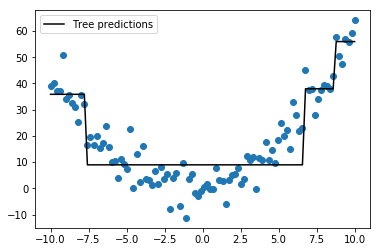

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)

X = np.linspace(-10, 10, 100)
y = 0.5*X**2 + X + 6*np.random.randn(100)

tree_reg1.fit(X.reshape(-1, 1), y)

y_predict = tree_reg1.predict(X.reshape(-1, 1))

plt.scatter(X, y)
plt.plot(X, y_predict, "k", label="Tree predictions")
plt.legend()
plt.show()

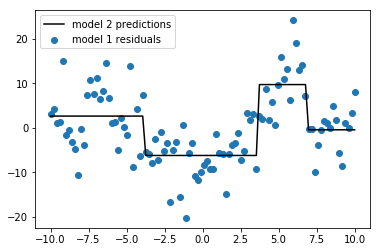

In [12]:
# now calculat the residuals
y2 = y - tree_reg1.predict(X.reshape(-1, 1))

# train a new model on these residuals
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X.reshape(-1, 1), y2)

y_predict2 = tree_reg2.predict(X.reshape(-1, 1))

plt.scatter(X, y2, label="model 1 residuals")
plt.plot(X, y_predict2, "k", label="model 2 predictions")
plt.legend()
plt.show()

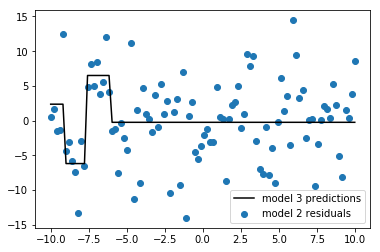

In [13]:
# repeat
y3 = y2 - tree_reg2.predict(X.reshape(-1, 1))

# train a new model on these residuals
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X.reshape(-1, 1), y3)

y_predict3 = tree_reg3.predict(X.reshape(-1, 1))

plt.scatter(X, y3, label="model 2 residuals")
plt.plot(X, y_predict3, "k", label="model 3 predictions")
plt.legend()
plt.show()

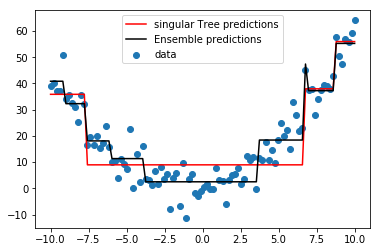

In [14]:
# now sum the three different models

y_pred = sum(tree.predict(X.reshape(-1, 1)) for tree in (tree_reg1, tree_reg2, tree_reg3))
plt.scatter(X, y, label="data")
plt.plot(X, y_predict, "r", label="singular Tree predictions")
plt.plot(X, y_pred, "k", label="Ensemble predictions")
plt.legend()
plt.show()

As you can see, as more predictors are added to the ensemble, the ensemble prediction gets better.

This method can be accomplished using sklearn.ensemble.GradientBoostingRegressor which uses decision trees as its base estimator and has similial hyperparameters. The learning_rate hyperparameter scales the contribution from each tree. For low values, more trees will be needed, but the predictions will generalise better.

To determine the optimal number of trees:

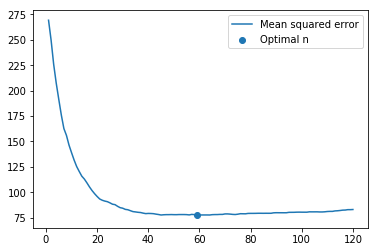

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_val, y_train, y_val = train_test_split(X.reshape(-1, 1), y, random_state=42)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n = np.argmin(errors)

n_list = list(range(1, 121))
plt.plot(n_list, errors, label="Mean squared error")
plt.scatter(best_n, errors[best_n+1], label="Optimal n")
plt.legend()
plt.show()

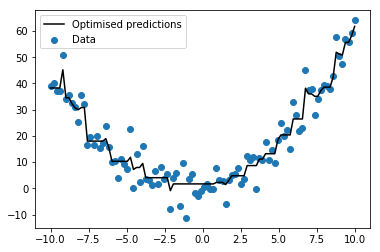

In [16]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n)
gbrt_best.fit(X.reshape(-1, 1), y)

plt.scatter(X, y, label="Data")
plt.plot(X, gbrt_best.predict(X.reshape(-1, 1)), "k", label="Optimised predictions")
plt.legend()
plt.show()

*Stochastic Gradient boosting* is where each tree is trained on a random subset of the training instances. Each predictor is still evaluated on the whole training set, in order to calculate the residuals, but not all of these residuals are then passed into the next predictor for training.

## Stacking

Short for *Stacked generalisation*, stacking involves training a model to aggragate the predictions from an ensemble instead of taking an average or by voting. The training set is split into two subsets. An ensemble of models is trained on one of the subsets. Each model in the ensemble then makes predictions on the second subset. This way, the second subset is 'clean' and never before seen by the models. Each model makes a prediction which creates a new set of instances. 

If there are m models, then the new set of instances has m features, one feature corresponding to the output from each model. This new set of instances is passed to another model, along with the correct target values. This new model, called the *blender* or *meta learner*, is trained on this new set. So the blender learns to make predictions based not on the orginal features, but on the predictions made by the ensemble.

Adittional layers can be made by making multiple layers of blenders. The key to remember is to split the dataset into the correct number of subsets so each layer is trained on 'new' instances.

Sklearn does not have implementation for stacking. (see exercises)

## Exercises

1. Provided the 5 models are sufficiently different, there is a chance that combining them will improve the results. However, at 95% precision, the models are already performing extremely well and it is unlikely that making an ensemble will help in this case. There is also the likely possibility that they are overfitting the training set. Considering that they are all trained in the exact same trainnig data, if they are overfitting, then aggragating their results will still be overfitting. In total, it is unlikely that an ensemble will help in this case. You would be better off training the models on different subsets of the training data set to avoid repeated overfitting errors.

2. In hard voting, the final prediction is taken as the most frequent (in the case of classifiers) or average (in the case of regressors) prediction by the individual models. Each predictor in the ensemble has equal vote regardless of how confident that predictor is in its prediction. In soft voting, the predictors confidence is taken into account as a weighting. Thus more confident predictors will be given more influence over the aggragated prediction. This however requires the the predictors have some way of returning a prediction probability (such as predict_probas method for Scikit-Learn models).

3. Bagging and pasting ensemble techniques involve training many models on different subsets. Each model is independent of the others so the models can be trained in parallel. This can be done via multiple cores or distributed across multiple servers. The same goes for random forests which as bagging algorithms. Boosting and staacking ensembles are different in that the models are trained sequentially. Each model depends on the results of the previously trained models. For this reason, they cannot be trained in parallel. Boosting and stacking models then do not scale as well as bagging and pasting models.

4. The benefit of out-of-bag evaluation is that you can obtain an evaluation of your models without having to test the models on the test set. Since the model is not trained on the oob data, it is possible to obtain an completely unbiased evaluation without the need for an aditional validation set.

5. Extra-trees take a stochastic approach to builing the decision trees. Whereas the decision tree algorithms try to find the most optimal threshold along a feature for a split at a particular node, the extra-trees algorithm selects random thresholds. This randomness helps create more diverse models which in turn helps reduce overfitting and the cost of increased bias. In a sense it is another form of regularisation. Because the thresholds are taken at random, extra-trees are faster than random-forests to train. In making predictions, they aree neither faster nor slower.

6. If the AdaBoost ensemble is underfitting to the training data, you can increase the n_estimators hyperparameter to increase the number of predictors. You can also reduce the regularisation of the base estimator class.

7. Decreasing the learning rate will prevent the ensemble from overfitting the data. The model will end up generalising better. You can also try early stopping when you have enough estimators.

In [17]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
X, y = mnist["data"], mnist["target"]

Since the MNIST dataset is already split for us. I will then keep the daatset small since SVMs do not scale well with large datasets:

In [18]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

# Shuffle the training set and then split into training and validation
np.random_seed = 42
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

X_train, y_train, X_val, y_val = X_train[:5000], y_train[:5000], X_train[59000:], y_train[59000:]

So the training set contains 5000 isntances, the validation set contains 1000 instances and the test set contains 10000 instances.

Lets try a linear SVM classifier, a Random Forest classifier and an Extra-Trees clasifier. I wont use any regularisation just to see how making the ensemble improves the models (I choose a LinearSVM instead of using a kernel since the ordinary SVC class scales poorly with large datasets and is very slow on this computer):

In [21]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC

rnd_clf = RandomForestClassifier()
extra_clf = ExtraTreesClassifier()
svm_clf = LinearSVC()

In [22]:
for clf in (rnd_clf, extra_clf, svm_clf):
    clf.fit(X_train, y_train)
    score = accuracy_score(y_val, clf.predict(X_val))
    print(clf.__class__.__name__, score*100, "%")

RandomForestClassifier 89.60000000000001 %
ExtraTreesClassifier 89.9 %
LinearSVC 82.0 %


So for this dataset, the random forest and extra-trees models perform the best, wihch is not surprising as they are themselves ensembles. The LinearSVC model performed the worst, by 82% still isn't bad. Lets see if this can be improved by aggragating their results:

In [27]:
hard_clf = VotingClassifier(
    estimators=[('rf', rnd_clf), ('extra', extra_clf), ('svc', svm_clf)],
    voting='hard'
)

soft_clf = VotingClassifier(
    estimators=[('rf', rnd_clf), ('extra', extra_clf)],
    voting='soft'
)

for name, clf in zip(['Hard voting:', 'Soft voting:'], [hard_clf, soft_clf]):
    clf.fit(X_train, y_train)
    score = accuracy_score(y_val, clf.predict(X_val))
    print(name, score*100, '%')

C:\Users\21493806\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Hard voting: 90.7 %
Soft voting: 92.2 %


C:\Users\21493806\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


So on the validation set, the ensemble performs better than each. Unfortunately, the LinearSVC class does not have a predict_probas method so it will not be able to contribute fairly in the soft voting scheme. Despite this, the soft voting still performs much better than all the rest.